<a href="https://colab.research.google.com/github/adamsyed3181/GenAI/blob/main/GenAI_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# the needed libraries
!pip install diffusers transformers accelerate



In [ ]:
import diffusers
import os

# Disable the problematic progress bar widgets
diffusers.logging.disable_progress_bar()
os.environ["TQDM_DISABLE"] = "1"

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

# Load the model into memory
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")






Prompt: Airplane landing on runway, 8k, raytracing
---



In [ ]:
# Create a generator with a fixed seed
generator = torch.Generator("cuda").manual_seed(1234)

pipe.set_progress_bar_config(disable=True)

image = pipe(
    prompt="Airplane landing on runway, 8k, Raytracing",
    num_inference_steps=5,

    # Adjust this value for your experiments:
    guidance_scale=30.0,

    generator=generator
).images[0]

image

Steps of generation:
---



In [ ]:
import torch
import matplotlib.pyplot as plt

generator = torch.Generator("cuda").manual_seed(1234)
intermediate_images = []

def latents_callback(pipe, step_index, timestep, callback_kwargs):
    # Capture every 5 iterations
    if (step_index + 1) % 5  == 0:
        latents = callback_kwargs["latents"]
        with torch.no_grad():
            # Decode and process latent to PIL
            latents = 1 / 0.18215 * latents
            image = pipe.vae.decode(latents).sample
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).float().numpy()
            pil_image = pipe.numpy_to_pil(image)[0]
            intermediate_images.append((step_index + 1, pil_image))

    return callback_kwargs

# Run the generation
final_image = pipe(
    prompt="Airplane landing on runway, 8k, Raytracing",
    generator=generator,
    num_inference_steps=50,
    guidance_scale=30.0,
    callback_on_step_end=latents_callback,
    callback_on_step_end_tensor_inputs=['latents']
).images[0]

# Add the final result to our list
intermediate_images.append((50, final_image))

# --- Display in a Matrix ---
cols = 3
rows = (len(intermediate_images) + cols - 1) // cols
# figsize is (width, height) in inches.
# Since we want roughly 1x1 inch images, we scale by the grid size.
plt.figure(figsize=(cols, rows))

for i, (step, img) in enumerate(intermediate_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"Step {step}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


Negative prompt:
---



In [ ]:
# Create a generator with a fixed seed
generator = torch.Generator("cuda").manual_seed(1234)

pipe.set_progress_bar_config(disable=True)

prompt = "A cyberpunk hacker terminal showing green lines of code, reflection of a neon city on the screen, 8k, raytracing"
neg_prompt = "green, text, letters, numerals, matrix"

image = pipe(
    prompt=prompt,
    negative_prompt=neg_prompt,
    num_inference_steps=50,
    guidance_scale=7.5,
    generator=generator
).images[0]

display(image)

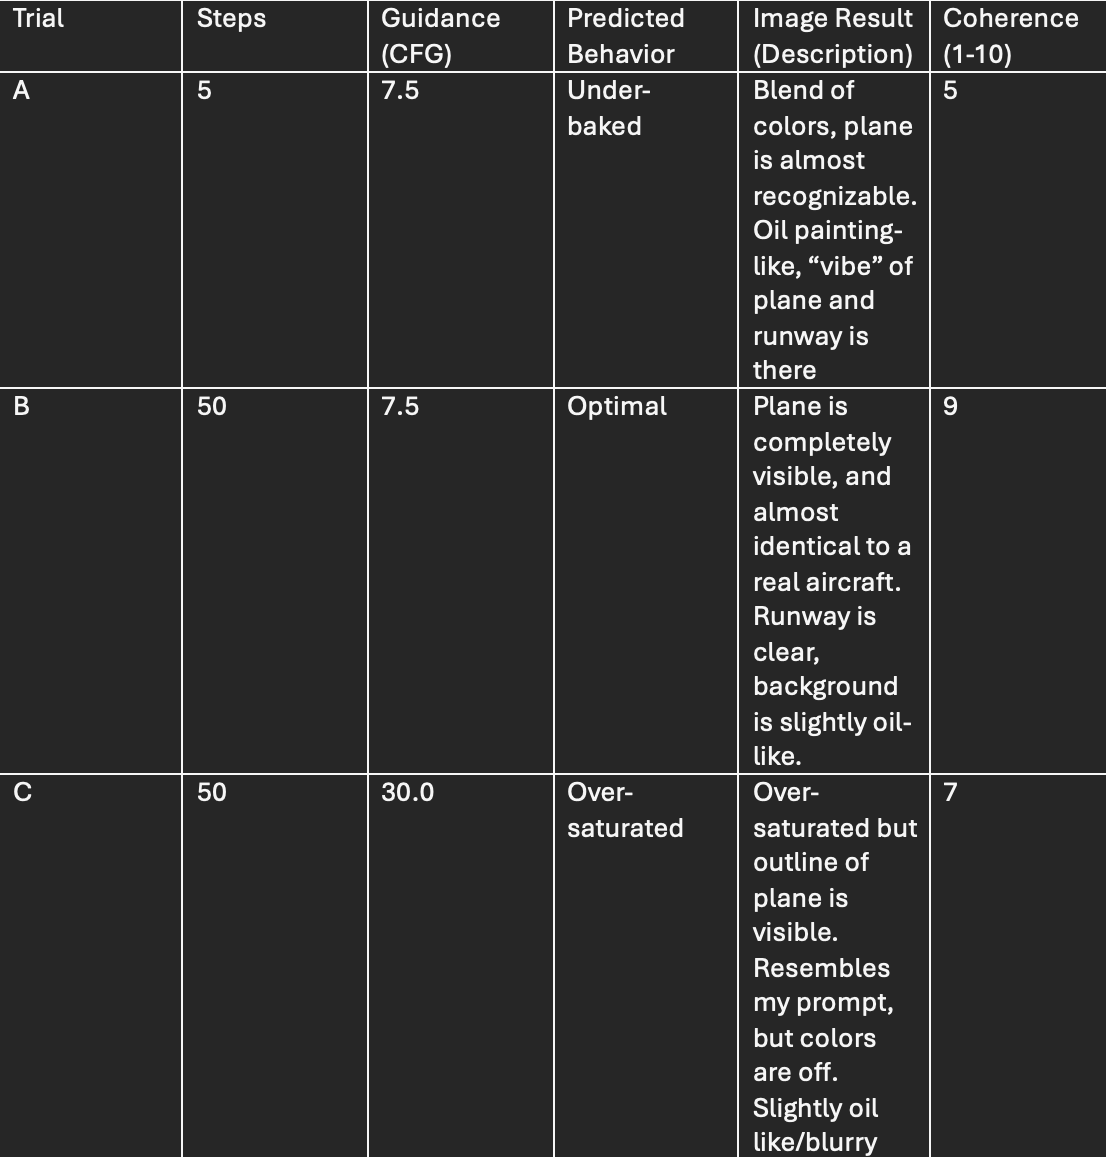

Analysis:
---

1.	Compare Trial A to Trial B. Why does 5 steps result in a blurry ghost of an image?
Between Trial A and Trial B, the image becomes clearer as the steps increase. The cause of the “blurry ghost of an image” is because the agent has less time to denoise the image. It stops early, leading the image to be unfinished/unrefined.
2.	In Trial C, look at the colors. Did they become more realistic, or did they start to become too bright/dark? Explain why.
In Trial C the colors of the image are too bright in lit regions and too dark in dimmer, making the picture look over-saturated. When you increase the guidance scale to the high scale (15-30+) it causes the model to follower the user’s prompt word-for-word. The mathematical weights are pushed to their limit leading to extreme contrasts in colors.
3.	Doubling the steps does take longer to generate the image. The AI agent needs more time to denoise image when steps are high, causing the hardware to work harder and longer. When there is less steps, it takes less time to denoise the image making it easier on the system to process this generation.
*   High steps: 7 sec
*   Low steps: 1 sec


Extra Credit
---
*   prompt = "A cyberpunk hacker terminal showing green lines of code, reflection of a neon city on the screen, 8k, raytracing"
*   neg_prompt = "green, text, letters, numerals, matrix"

Overall, the negative prompt greatly improved the image generation compared to without the negative prompt.

The original prompt might have been too crowded with descriptions and made the generation muddy. The negative prompt dialed it back and didn’t overextend the model. It restricted its search in the latent space and created an image that was more focused; this can be a powerful tool by this exact characteristic, by limiting its words it has to search through it focuses the agent and is able to produce a more precise image.

The image sticks to its cyberpunk theme and looks more like a hacker terminal, minus the green text and numbers, and rather looks like the semblance of a computer screen.

**Rating: 8**
